# Train NN on single digits 
Here we assume that MNIST synthetic Preprocessing is done, we simply load the single digits set from the MNIST synthetic training set and add it to the regular MNIST training set 

In [1]:
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from keras.datasets import mnist
import torch
import numpy as np
import argparse
import torch.nn as nn
import torch.utils.data as data_utils
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torch.optim as optim

Using TensorFlow backend.


Same function used in MNIST preprocessing to extract single digits from the MNIST synthetic images

In [ ]:
def extract_num(image, min_pixel=4):
    """
    Take as input an image containing a sequence of written numbers and output each number in the original image
    as a individual images
    image: image containing the sequence number
    min_pixel : number of pixel minimal for a section to be considered a number (initialize as a 4x4 box)
    """
    image_copy = image.copy()
    image_copy2 = image.copy()
    #Binary threshold on the  original image to highlight the are where there are numbers
    ret, thresh = cv2.threshold(image.copy(),2, 255,cv2.THRESH_BINARY_INV)
    #Countour the numbers
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    preprocessed_digits = [] #array to contain the individual numbers' images
    
    # We sort the countours by their position on the x axis to select the numbers in the images from left to right
    contours_array = np.empty((0,4),dtype=int)
    for c in contours:
        x,y,w,h = cv2.boundingRect(c) #extract the coordinates of the box around the number
        contours_array = np.concatenate((contours_array,[[x,y,w,h]]), axis=0)
    columnIndex = 0
    # Sort contour array by the first column (containing x-axis value)
    sortedc = contours_array[contours_array[:,columnIndex].argsort()]
    sortedc = np.delete(sortedc, (0), axis=0)
    
    #print(sortedc)
    x_pred=0
    y_pred=0
    w_pred=0
    h_pred=0
    for c in range(len(sortedc)):
        x,y,w,h = sortedc[c]
        #print('widht: ',w,'height: ',h)
        if (h<=min_pixel+1 or w<=min_pixel/2): 
            #eliminate countours that are too small (likely not a number) or too big (box around the whole image)
            continue
        if (x + w < x_pred+w_pred-2 ):
          #eliminate if there is some overlap
          x_pred =x
          w_pred =w
          h_pred=h
          continue
        if x < x_pred+w_pred-3:
          x_pred =x
          w_pred =w
          h_pred=h
          continue
        x_pred =x
        w_pred =w
        h_pred=h
        # Creating a rectangle around the digit in the original image
        cv2.rectangle(image_copy, (x,y), (x+w, y+h), color=100, thickness=1)
    
        # Cropping out the digit from the image corresponding to the current contours in the for loop
        digit =image_copy2[y:y+h, x:x+w]
        
        # Resizing that digit to (24,24)
        resized_digit = cv2.resize(digit, (24,24))
    
        # Padding the digit with 2 pixels in each side to produce the image of (28, 28)
        padded_digit = np.pad(resized_digit, ((2,2),(2,2)), "constant", constant_values=0)
        preprocessed_digits.append(padded_digit)  
    inp = np.array(preprocessed_digits)
    return inp, image_copy

# Load the preprocessed au augmented images 

In [ ]:
### DATA augmentation set combination
#load prep
combined_rest_train_imgs=np.load('data/combined_rest_train_imgs_OG.npy')
combined_rest_train_labels=np.load('data/combined_rest_train_labels_OG.npy')

valid_modified_mnist=np.load('data/valid_modified_mnist.npy')
valid_labels_modified_mnist=np.load('data/valid_labels_modified_mnist.npy')

combined_rest_train_imgs = combined_rest_train_imgs.reshape(123262,1,28,28)
combined_rest_train_labels = combined_rest_train_labels.reshape(123262,)

rotated_pos_10 = np.load('data/rotated_pos_10.npy')
rotated_pos_10_labels = np.load('data/rotated_pos_10_labels.npy')
rotated_neg_10 = np.load('data/rotated_neg_10.npy')
rotated_neg_10_labels = np.load('data/rotated_neg_10_labels.npy')
trans_right_pos = np.load('data/trans_right_pos.npy')
trans_right_pos_labels = np.load('data/trans_right_pos_labels.npy')
trans_left_pos = np.load('data/trans_left_pos.npy')
trans_left_pos_labels = np.load('data/trans_left_pos_labels.npy')
trans_up_pos = np.load('data/trans_up_pos.npy')
trans_up_pos_labels = np.load('data/trans_up_pos_labels.npy')

X_train = np.concatenate((combined_rest_train_imgs,rotated_pos_10,rotated_neg_10,trans_right_pos,trans_left_pos,trans_up_pos),axis =0)
y_train = np.concatenate((combined_rest_train_labels,rotated_pos_10_labels,rotated_neg_10_labels,trans_right_pos_labels,trans_left_pos_labels,trans_up_pos_labels),axis =0)



# Define a sequential Network (Keras)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras import regularizers                                                           

In [ ]:
model_s = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(1,28,28)),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(256,activation='relu'),
    #tf.keras.layers.Dropout(.5, input_shape=(2,)),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(64, activation='softmax')
])
#model.add(Flatten())
model_s.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)

model_s.summary()

In [ ]:
print("Fit model on training data")
history = model_s.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=6,
)

In [ ]:
import time

start = time.time()
print("start timer :) ")
count = 0
correct = 0
predictions = []
for i in range(valid_modified_mnist.shape[0]): #loop over all images
    true_label = valid_labels_modified_mnist[i]
    inp = extract_num(valid_modified_mnist[i,:,:,:])[0] #extract 28 x 28 images of the single digits in each image
    #reshape inp to add the channel value
    
    sequence = inp.reshape(inp.shape[0],1,28,28)
    sequence_ts = tf.convert_to_tensor(sequence)
    p=[]
    for idx in range(np.shape(sequence)[0]):
        r = model_s.predict(sequence_ts[idx])
        digit = np.argmax(r)
        p.append(digit)

    if len(p) < 5:
      for k in range(5-len(p)):
        p.append(10)

    p = np.array(p)
    predictions = np.append(predictions, p)
    if (np.array_equal(p,true_label)):
      #print(i)
      correct += 1
    #print(true_label)
    #print(p)
    count += 1
    
    if count == (valid_modified_mnist.shape[0])/4:
      print("--------------------25% complete-----------------------")
    elif count == (valid_modified_mnist.shape[0])/2:
      print("--------------------50% complete-----------------------")
    elif count == 3*((valid_modified_mnist.shape[0])/4):
      print("--------------------75% complete-----------------------")

print("--------------------100% complete--------------------")
print("Dev set accuracy: ", correct/count)
end = time.time()
print(end - start)

In [ ]:
start = time.time()
print("start timer:)")
predictions = []
count_test = 0
for i in range(test_dataset.shape[0]):
  inp = extract_num(test_dataset[i,:,:,:])[0]
  s_test = inp.reshape(inp.shape[0],1,28,28)
  s_test_ts=tf.convert_to_tensor(s_test)
  pdx = []
  for idx in range(np.shape(s_test)[0]):
    result = model_s.predict(s_test_ts[idx])
    d = np.argmax(result).astype(str)
    #print(d)
    pdx.append(d)

  if len(pdx) < 5:
    for k in range(5-len(pdx)):
      pdx.append('10')
  
  #print(pd)
  #pd = np.array(pd)
  pd_after = ''
  for element in pdx:
    pd_after += element


  #print(pd_after)
  predictions = np.append(predictions,pd_after)
  predictions = np.array(predictions).astype(str)

  #print(type(predictions))
  #if count_test > 4:
  #  break
  #print(predictions)

  if count_test == (test_dataset.shape[0])/4:
    print("------25% complete-----")
  elif count_test == (test_dataset.shape[0])/2:
    print("-----50% complete-----")
  elif count_test == 3*((test_dataset.shape[0])/4):
    print("-----75% complete-----")

  count_test += 1
print("-----100% complete-----")
end = time.time()
print(end - start)

In [ ]:
#print(predicted_labels)
df = pd.DataFrame(list(zip(indices, (predictions).astype('str'))),columns =['Id','Label']) 
print(df)
df.to_csv('r.csv',index=False)

# Define convolutional neural network 1

In [ ]:
#define a convolutional neural network 1

import torch.nn as nn
import torch.nn.functional as F

class Net1(nn.Module):
    def __init__(self):
        super(Net1,self).__init__()
        # 1 input image channel, 10 ouput channels, 5x5 square convolution
        self.conv1 = nn.Conv2d(1,10,kernel_size = 5)
        self.conv2 = nn.Conv2d(10,20,kernel_size = 5)
        self.conv2_drop = nn.Dropout2d()
        # an affine operation: y = Wx+b
        self.fc1 = nn.Linear(320,50)
        self.fc2 = nn.Linear(50,10)
        #self.fc3 = nn.Linear(128,10)
      
    def forward(self,x):
        x = F.relu(F.max_pool2d(self.conv1(x),2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)),2))
        x = x.view(-1,320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        #x = self.fc3(x)
        return x
    

# Define convolutional neural network 2

In [20]:

import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5* 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.shape[0], 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

# Grid Search


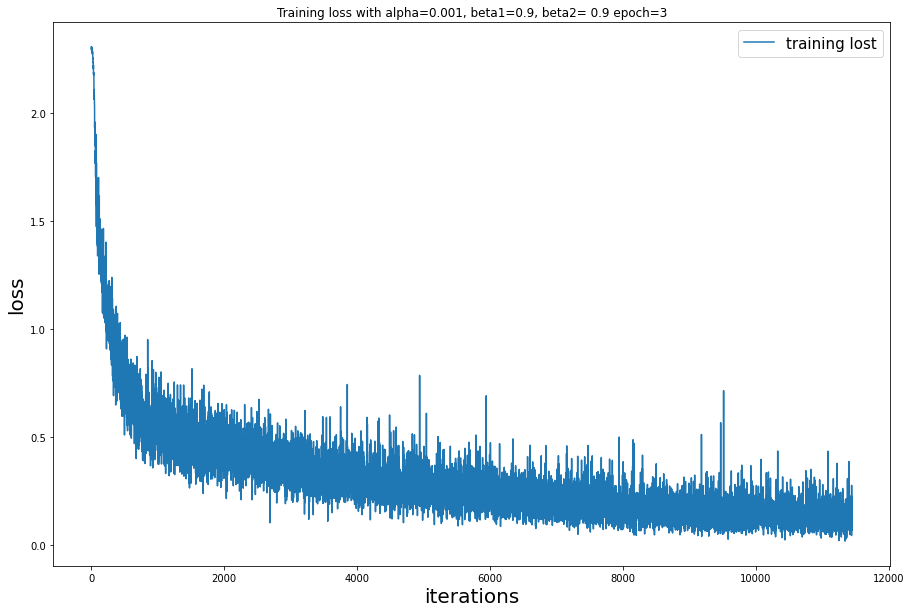

Finished Training
Accuracy:  93.36607142857143


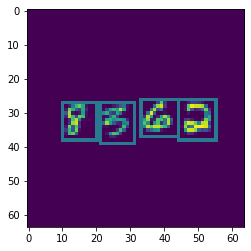

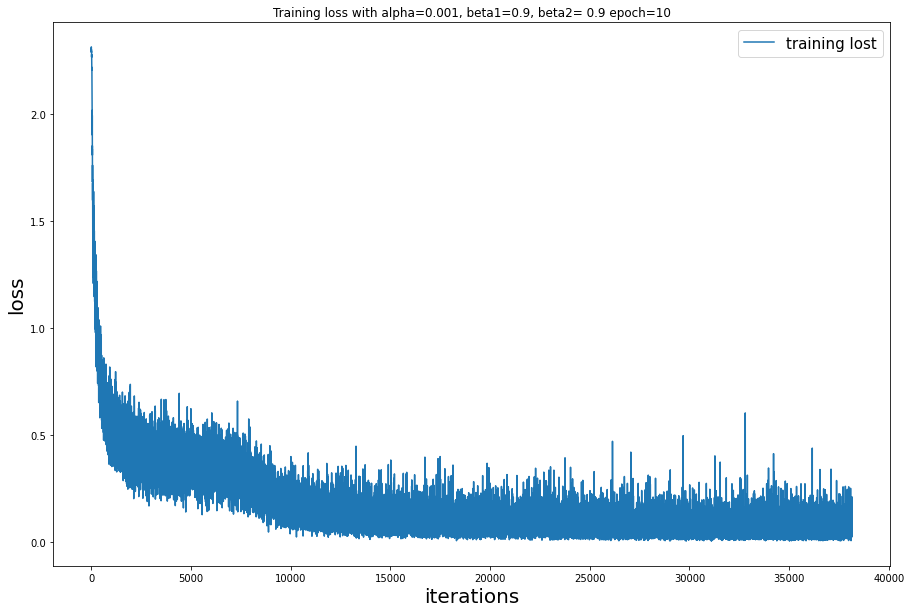

Finished Training
Accuracy:  95.83035714285714


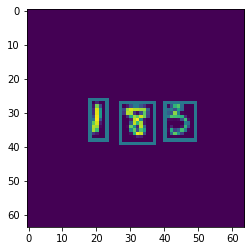

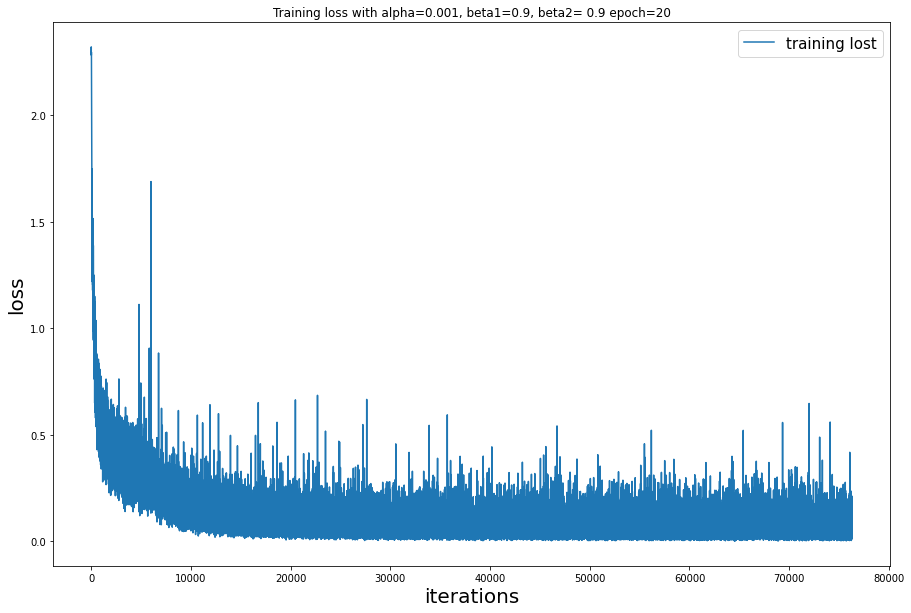

Finished Training
Accuracy:  96.71428571428571


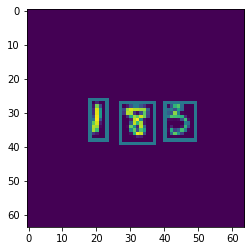

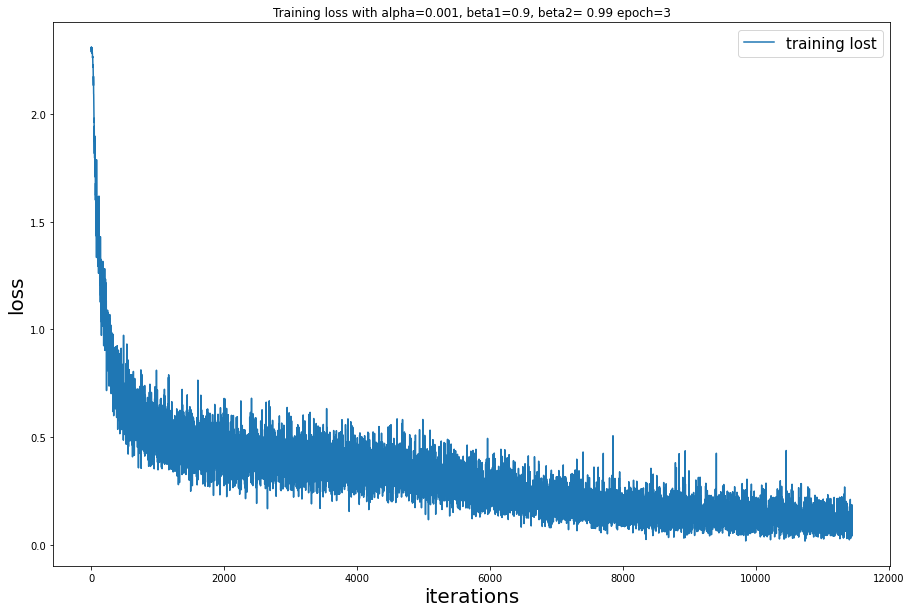

Finished Training
Accuracy:  94.83928571428571


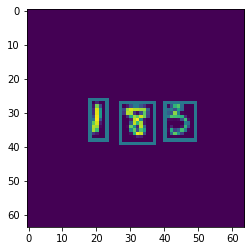

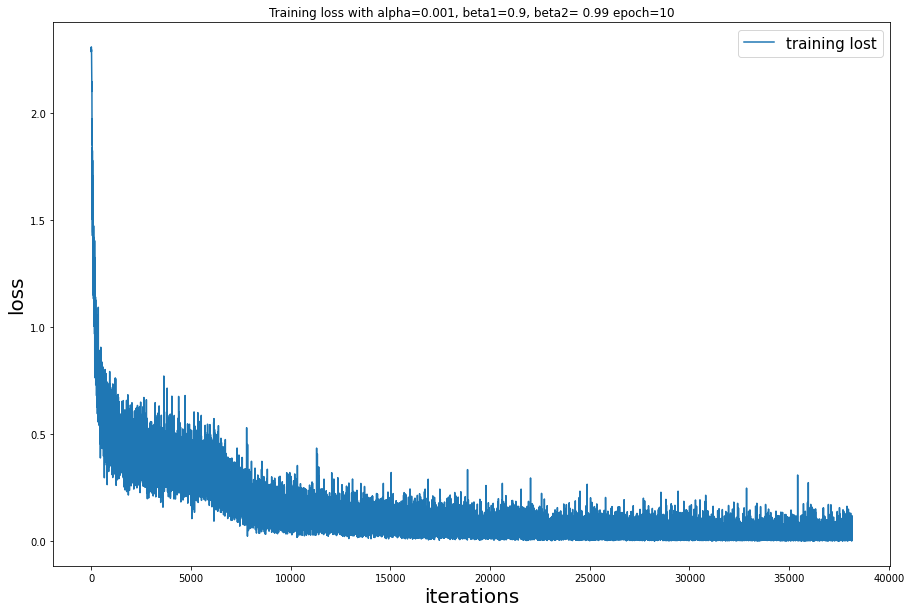

Finished Training
Accuracy:  97.84821428571429


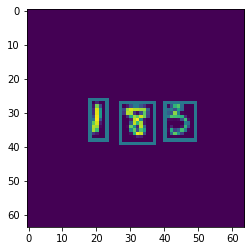

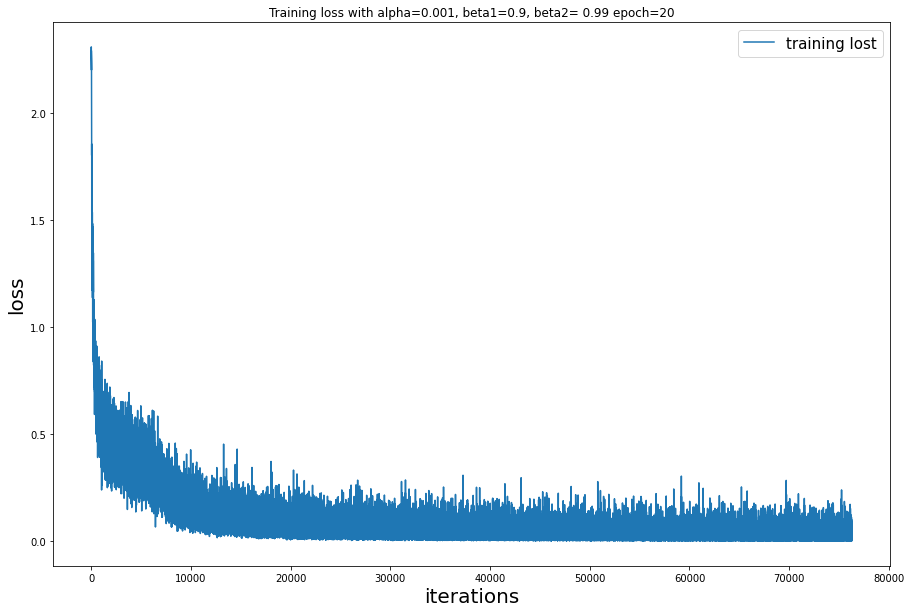

Finished Training
Accuracy:  98.08035714285714


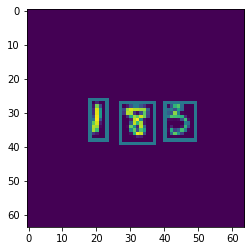

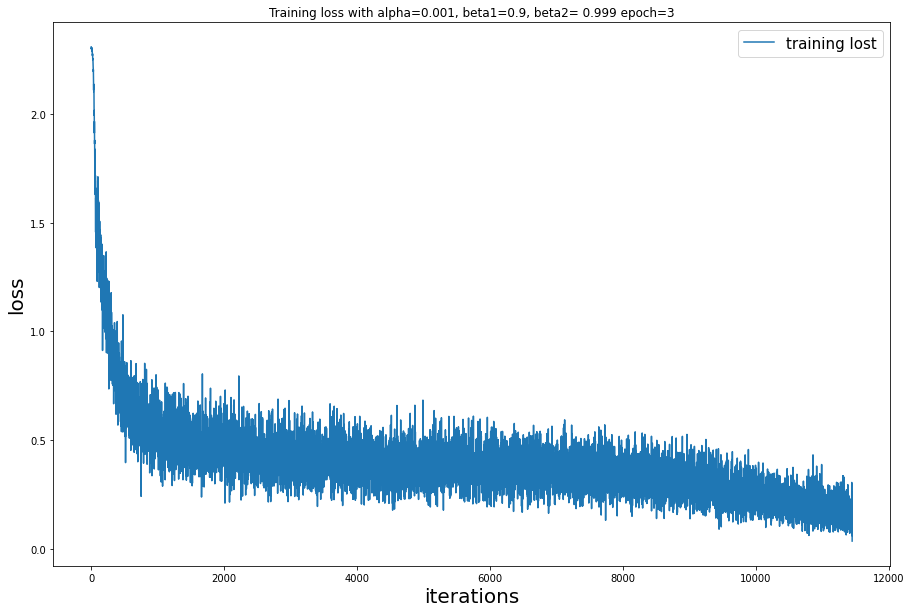

Finished Training
Accuracy:  93.34821428571429


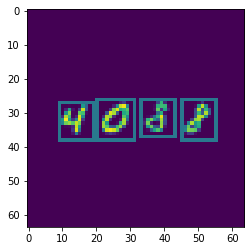

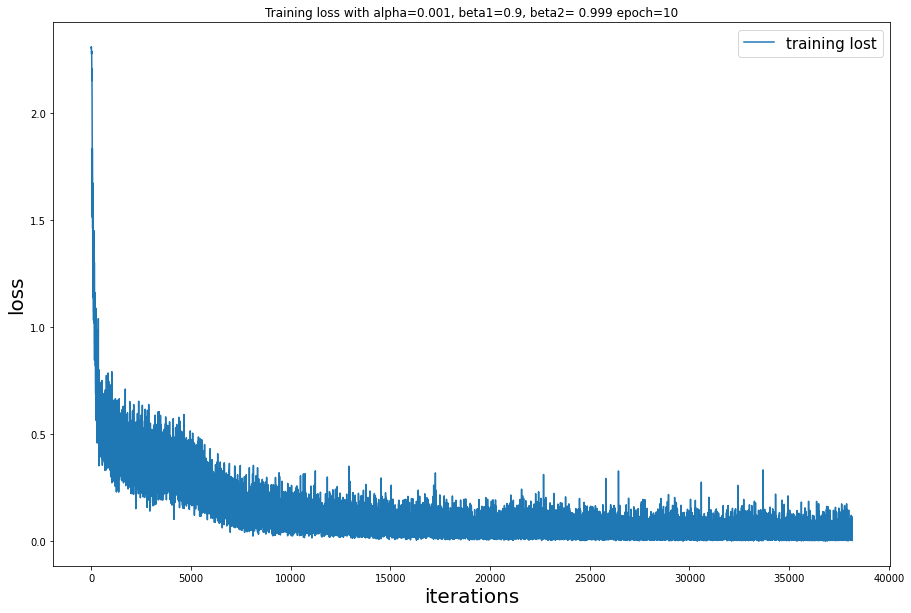

Finished Training
Accuracy:  97.58928571428571


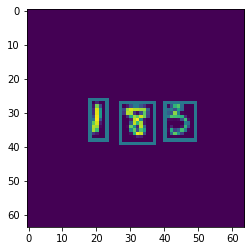

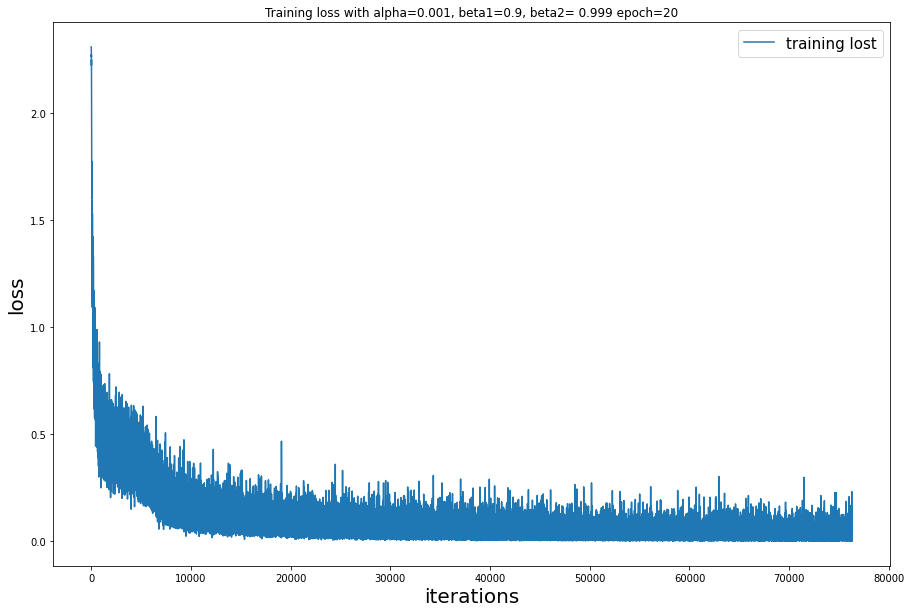

Finished Training
Accuracy:  97.77678571428571


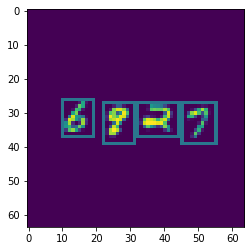

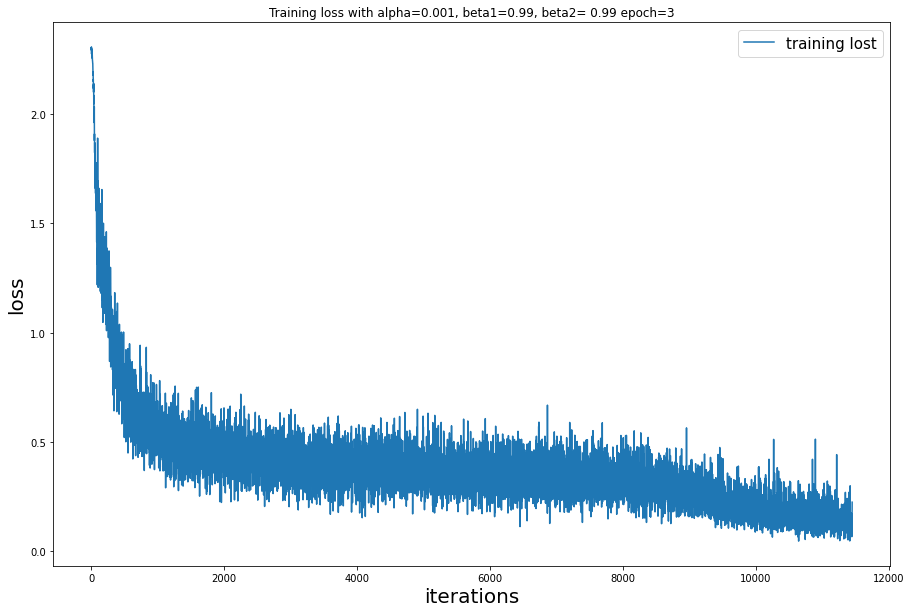

Finished Training
Accuracy:  94.84821428571429


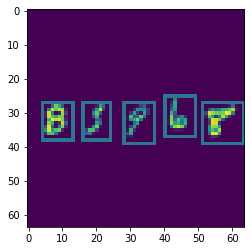

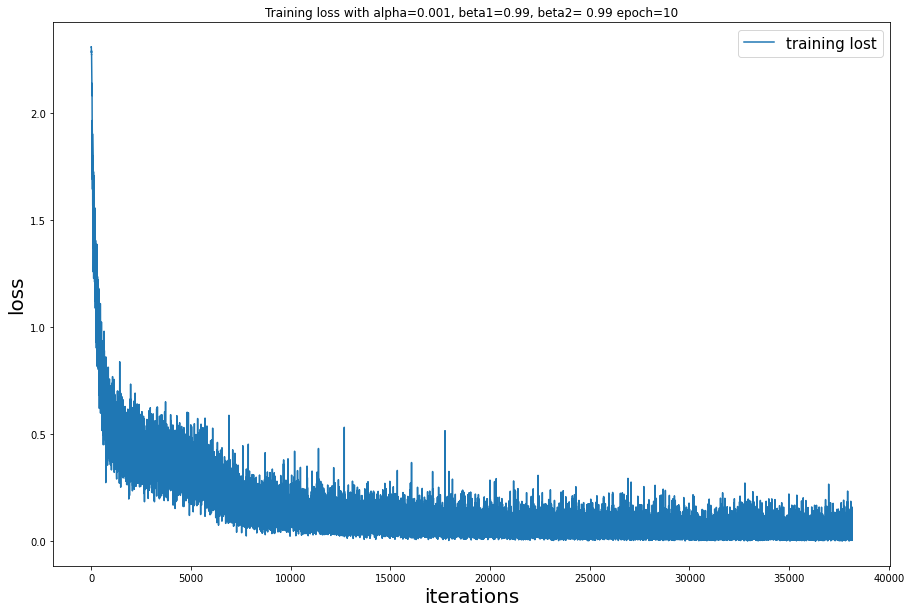

Finished Training
Accuracy:  97.05357142857143


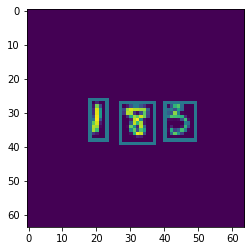

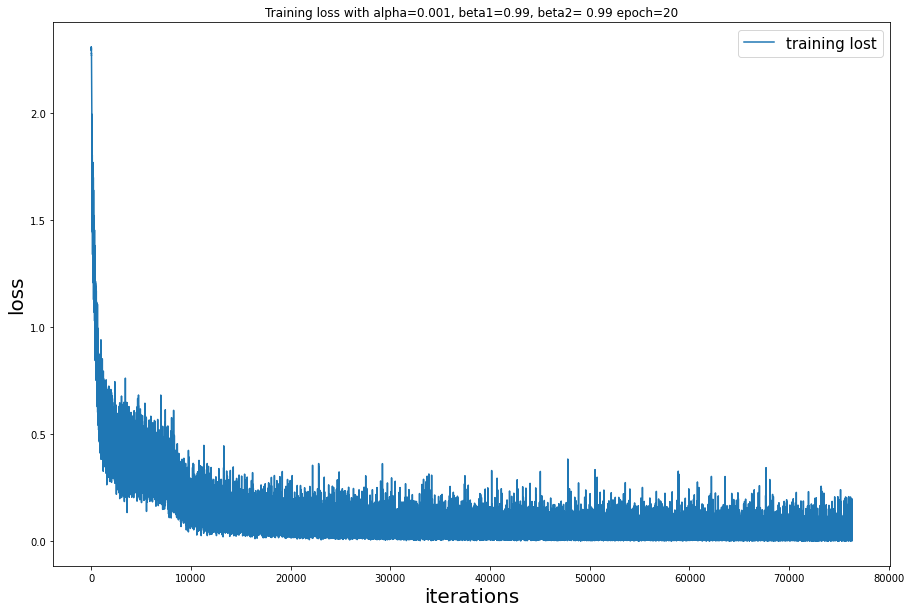

Finished Training
Accuracy:  97.41964285714286


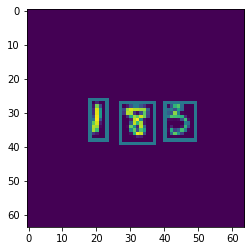

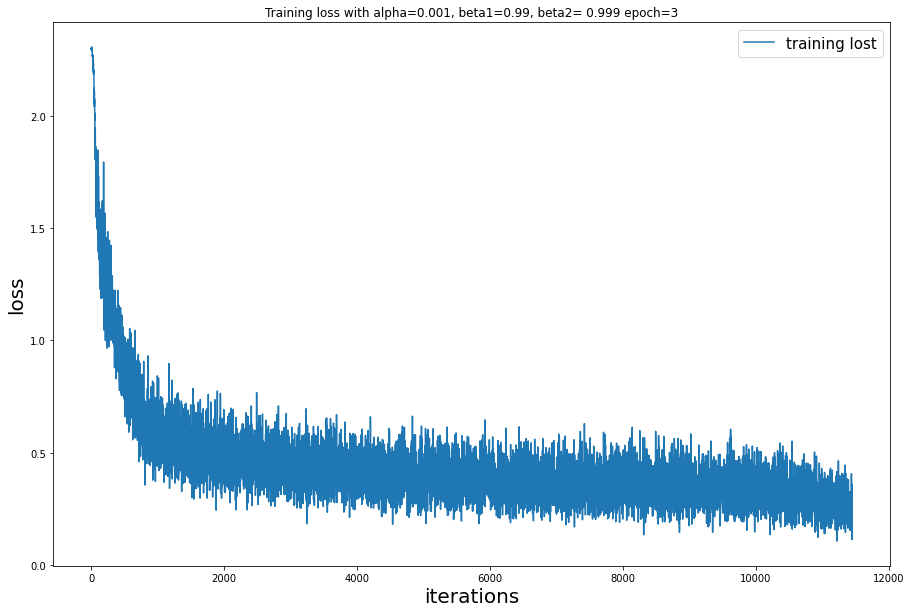

Finished Training
Accuracy:  94.24107142857143


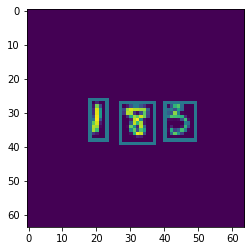

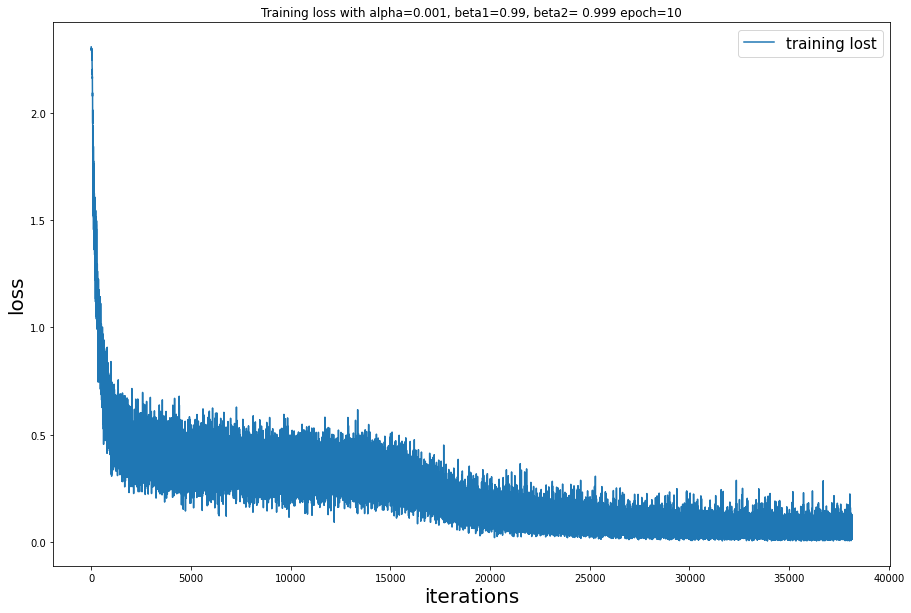

Finished Training
Accuracy:  97.79464285714286


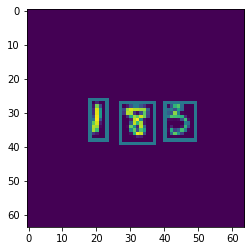

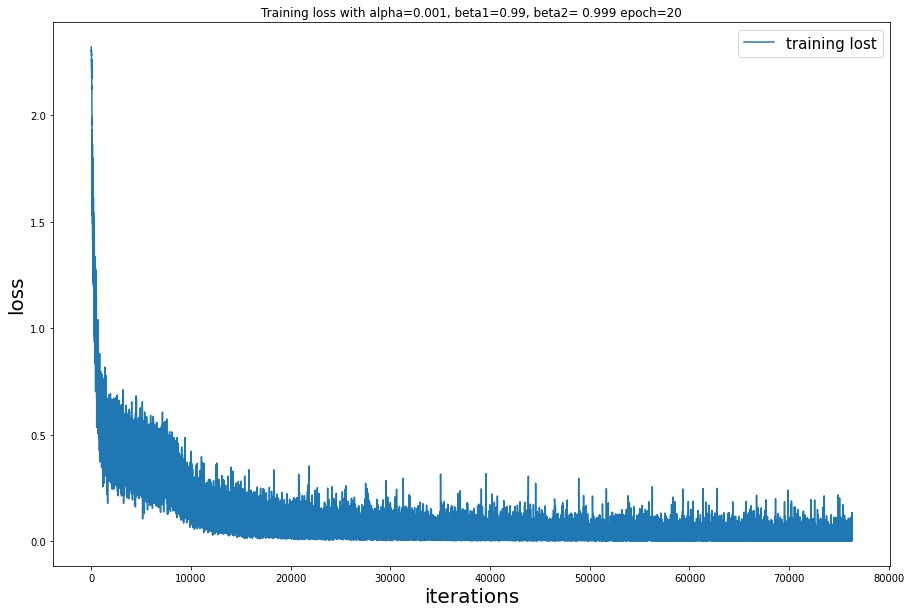

Finished Training
Accuracy:  98.53571428571429


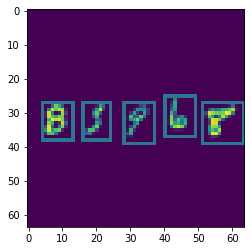

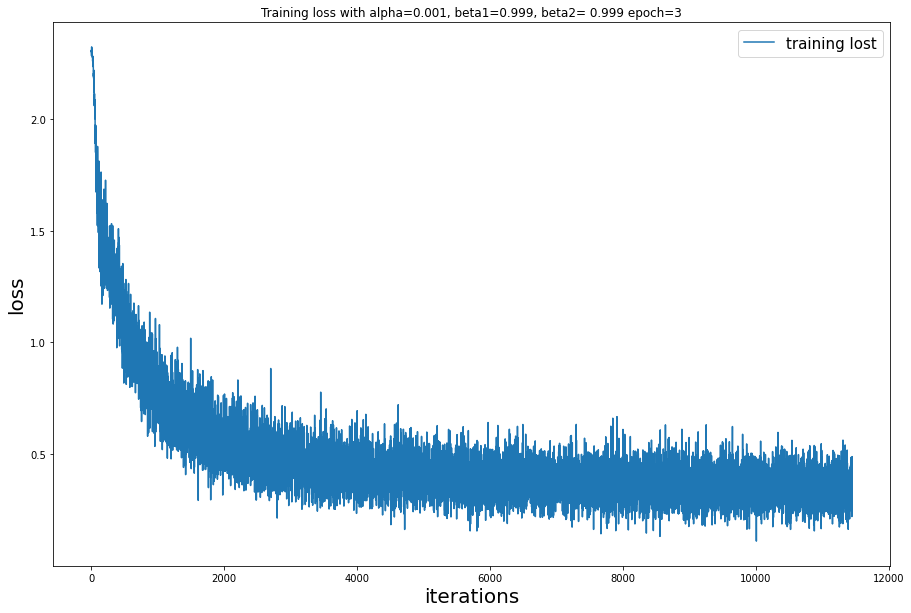

Finished Training
Accuracy:  94.25892857142857


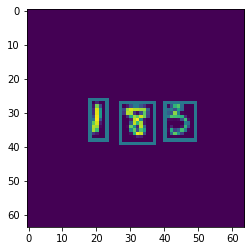

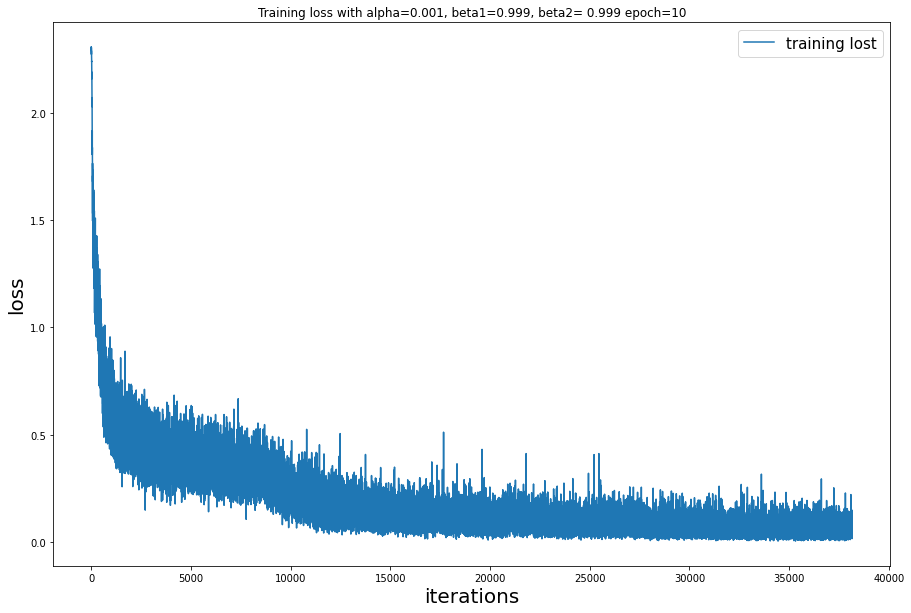

Finished Training
Accuracy:  96.64285714285714


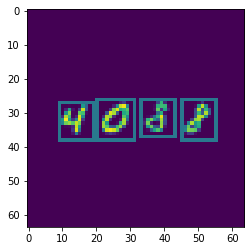

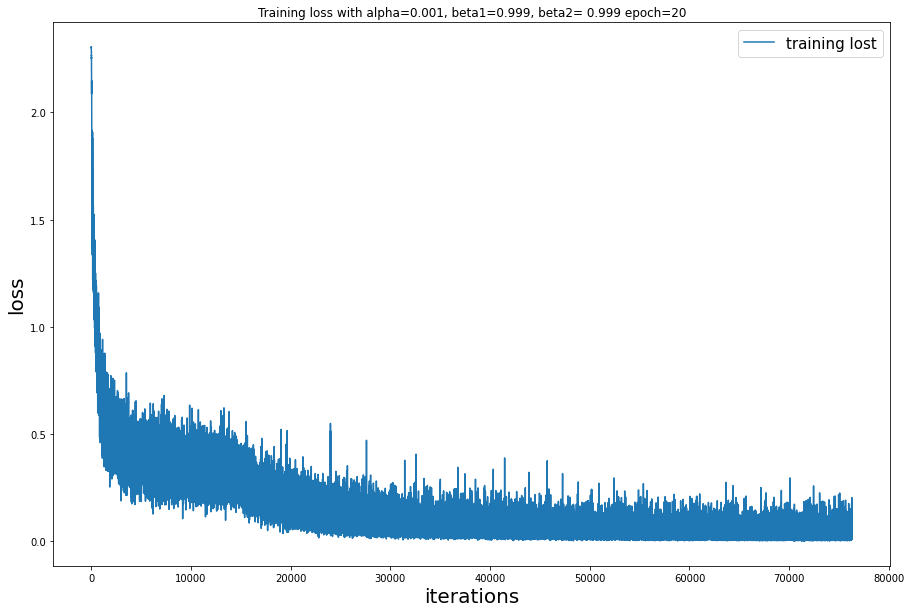

Finished Training
Accuracy:  97.64285714285714


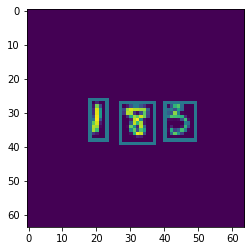

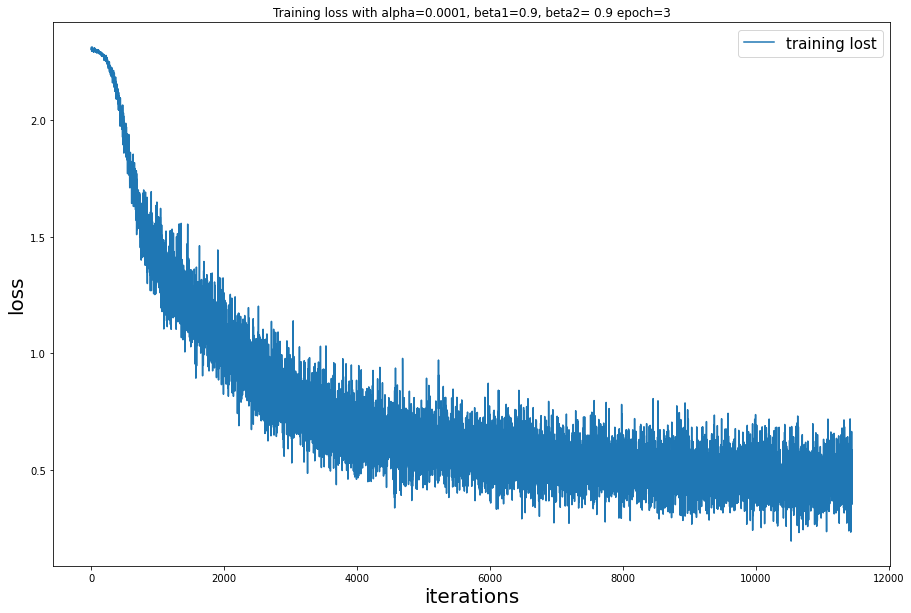

Finished Training
Accuracy:  85.55357142857143


KeyboardInterrupt: ignored

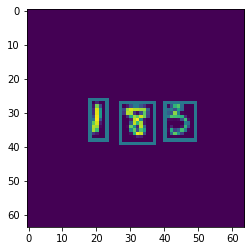

In [ ]:
X_train_tensor = torch.from_numpy(X_train)
y_train_tensor = torch.from_numpy(y_train)
datasets=data_utils.TensorDataset(X_train_tensor, y_train_tensor)
dataset = torch.utils.data.DataLoader(datasets, batch_size=64 ,
                                          shuffle=True, num_workers=4)

# Assuming that we are on a CUDA machine, this should print a CUDA device:
validation_accuracy = []
alpha_range=[0.001,0.0001]
beta_range=[0.9,0.99,0.999]
beta_range_2=[0.9,0.99,0.999]
epoch_range = [3,10,20]
for alpha in alpha_range:
  for beta_1 in beta_range: 
    for beta_2 in beta_range_2:
      for e in epoch_range:
        if beta_1> beta_2:
          continue
        net = Net()
        loss_plot = []
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(net.parameters(),lr=alpha, betas=(beta_1, beta_2), eps=1e-08, weight_decay=0, amsgrad=False)
        for epoch in range(e):  # loop over the dataset multiple times
            running_loss = 0.0
    
            for i,(inputs,labels) in enumerate(dataset):
              inputs = inputs/255
          # zero the parameter gradients
              optimizer.zero_grad()

          # forward + backward + optimize
              outputs = net(inputs.float())
              loss = criterion(outputs, labels.long())
              loss_plot.append(loss)
              loss.backward()
              optimizer.step()

          # print statistics
              running_loss += loss.item()
        
              if i % 100 == 101:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
              i=i+1
        plt.figure(figsize=(15,10))
        plt.plot(range(len(loss_plot)), loss_plot, label='training lost')
        title = str('Training loss with alpha='+str(alpha)+', beta1='+str(beta_1)+', beta2= '+str(beta_2)+' epoch='+str(e))
        plt.title(title)
        plt.legend(prop={'size': 15})
        plt.xlabel('iterations',fontsize=20)
        plt.ylabel('loss',fontsize=20)
        plt.tight_layout
        #plt.savefig('/content/drive/MyDrive/COMP 551/mini_project3/'+title+'_128.png',dpi=300)
        plt.show()
        print('Finished Training')
        valid_modified_mnist=np.load('data/valid_modified_mnist.npy')
        valid_labels_modified_mnist=np.load('data/valid_labels_modified_mnist.npy')
        correct =0
        total=0
        for i in range(valid_modified_mnist.shape[0]): #loop over all images
    
            inp,img = extract_num(valid_modified_mnist[i,:,:,:]) #extract 28 x 28 images of the single digits in each image
    
                  #reshape inp to add the channel value
            sequence = (inp.reshape(inp.shape[0],1,28,28))/255
    
            min_pi=4
            while(sequence.shape[0] == 0):
                min_pi = min_pi-1
                inp,img = extract_num(valid_modified_mnist[i,:,:,:], min_pixel=min_pi)
                      #plt.imshow(img.squeeze())
                      #plt.show()
                sequence = (inp.reshape(inp.shape[0],1,28,28))/255
            while(sequence.shape[0] > 5):
                min_pi = min_pi+ 1
                inp,img = extract_num(valid_modified_mnist[i,:,:,:], min_pixel=min_pi)
                      #plt.imshow(img.squeeze())
                      #plt.show()
                sequence = (inp.reshape(inp.shape[0],1,28,28))/255
                  #convert sequence of number into a tensor
            sequence_tensor = torch.from_numpy(sequence)
                  #convert the labels into a tensor as well
    
            labels_tensor = torch.from_numpy(valid_labels_modified_mnist[i])
    
                  #run the cnn on the images
            with torch.no_grad():
                outputs = net(sequence_tensor.float())
                _, predicted = torch.max(outputs.data, 1)
        
                predicted_good_order = predicted.numpy()
        
                if(len(predicted_good_order) < 5):
                    num_to_append = 5-len(predicted_good_order)
                    for j in range(num_to_append):
                        predicted_good_order = np.append(predicted_good_order,10)
                predicted_tensor=torch.from_numpy(predicted_good_order)
                      # check if predicted and true labels are the same
                total+= 1
                if torch.all(predicted_tensor.eq(labels_tensor)):
                      correct+=1
                else: 
                          plt.imshow(img.squeeze())
                          #plt.show()
                          #print('error: predicted: ',predicted_good_order,'True: ',labels_tensor, 'image: ',i)
        print('Accuracy: ',100 * correct / total)
        validation_accuracy.append(correct / total)
plt.plot(range(len(validation_accuracy)), validation_accuracy, label='validation accuracy')
title = str('Validation accuracy with alpha='+str(alpha)+', beta1='+str(beta_1)+', beta2= '+str(beta_2)+' epoch='+str(epoch))
plt.title(title)
plt.legend(prop={'size': 15})
plt.xlabel('model',fontsize=20)
plt.ylabel('accuracy',fontsize=20)
#plt.savefig('/content/drive/MyDrive/COMP 551/mini_project3/'+title+'.png',dpi=300)
plt.show()

In [ ]:
PATH = './single_num_v23_98.3_net.pth'
torch.save(net.state_dict(), PATH)

# Train the optimal model

In [56]:
        X_train_tensor = torch.from_numpy(X_train)
        y_train_tensor = torch.from_numpy(y_train)
        datasets=data_utils.TensorDataset(X_train_tensor, y_train_tensor)
        dataset = torch.utils.data.DataLoader(datasets, batch_size=128 ,
                                          shuffle=True, num_workers=4)
        net = Net()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(net.parameters(),lr=0.001, betas=(0.99, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

        for epoch in range(20):  # loop over the dataset multiple times

            running_loss = 0.0
    
            for i,(inputs,labels) in enumerate(dataset):
              inputs = inputs/255
          # zero the parameter gradients
              optimizer.zero_grad()

          # forward + backward + optimize
              outputs = net(inputs.float())
              loss = criterion(outputs, labels.long())
              loss.backward()
              optimizer.step()

          # print statistics
              running_loss += loss.item()
        
              if i % 100 == 99:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
              i=i+1

[1,   100] loss: 0.105
[1,   200] loss: 0.077
[1,   300] loss: 0.063
[1,   400] loss: 0.056
[1,   500] loss: 0.048
[1,   600] loss: 0.041
[1,   700] loss: 0.036
[1,   800] loss: 0.034
[1,   900] loss: 0.031
[1,  1000] loss: 0.030
[1,  1100] loss: 0.029
[1,  1200] loss: 0.029
[1,  1300] loss: 0.027
[1,  1400] loss: 0.026
[1,  1500] loss: 0.025
[1,  1600] loss: 0.025
[1,  1700] loss: 0.025
[1,  1800] loss: 0.023
[1,  1900] loss: 0.024
[1,  2000] loss: 0.023
[1,  2100] loss: 0.023
[1,  2200] loss: 0.022
[1,  2300] loss: 0.022
[1,  2400] loss: 0.023
[1,  2500] loss: 0.022
[1,  2600] loss: 0.022
[1,  2700] loss: 0.022
[1,  2800] loss: 0.021
[1,  2900] loss: 0.021
[1,  3000] loss: 0.022
[1,  3100] loss: 0.022
[1,  3200] loss: 0.021
[1,  3300] loss: 0.021
[1,  3400] loss: 0.020
[1,  3500] loss: 0.020
[1,  3600] loss: 0.021
[1,  3700] loss: 0.021
[1,  3800] loss: 0.020
[2,   100] loss: 0.020
[2,   200] loss: 0.020
[2,   300] loss: 0.020
[2,   400] loss: 0.020
[2,   500] loss: 0.020
[2,   600] 

In [57]:
#torch.save(net.state_dict(), 'single_num_v_final.pth')

# Validation of the optimal model

In [58]:
valid_modified_mnist=np.load('data/valid_modified_mnist.npy')
valid_labels_modified_mnist=np.load('data/valid_labels_modified_mnist.npy')
correct =0
total=0
for i in range(valid_modified_mnist.shape[0]): #loop over all images
    
    inp,img = extract_num(valid_modified_mnist[i,:,:,:]) #extract 28 x 28 images of the single digits in each image
    
    #reshape inp to add the channel value
    sequence = (inp.reshape(inp.shape[0],1,28,28))/255
    
    min_pi=4
    while(sequence.shape[0] == 0):
        min_pi = min_pi-1
        inp,img = extract_num(valid_modified_mnist[i,:,:,:], min_pixel=min_pi)
        #plt.imshow(img.squeeze())
        #plt.show()
        sequence = (inp.reshape(inp.shape[0],1,28,28))/255
    while(sequence.shape[0] > 5):
        min_pi = min_pi+ 1
        inp,img = extract_num(valid_modified_mnist[i,:,:,:], min_pixel=min_pi)
        #plt.imshow(img.squeeze())
        #plt.show()
        sequence = (inp.reshape(inp.shape[0],1,28,28))/255
    #convert sequence of number into a tensor
    sequence_tensor = torch.from_numpy(sequence)
    #convert the labels into a tensor as well
    
    labels_tensor = torch.from_numpy(valid_labels_modified_mnist[i])
    
    #run the cnn on the images
    with torch.no_grad():
        outputs = net(sequence_tensor.float())
        _, predicted = torch.max(outputs.data, 1)
        
        predicted_good_order = predicted.numpy()
        
        if(len(predicted_good_order) < 5):
            num_to_append = 5-len(predicted_good_order)
            for j in range(num_to_append):
                predicted_good_order = np.append(predicted_good_order,10)
        predicted_tensor=torch.from_numpy(predicted_good_order)
        # check if predicted and true labels are the same
        total+= 1
        if torch.all(predicted_tensor.eq(labels_tensor)):
            correct+=1
        else: 
            print('error: predicted: ',predicted_good_order,'True: ',labels_tensor, 'image: ',i)
print('Accuracy: ',100 * correct / total)

error: predicted:  [1 7 9 1 9] True:  tensor([1, 7, 9, 1, 8], dtype=torch.int32) image:  2
error: predicted:  [ 7  0  7  2 10] True:  tensor([ 7,  0,  9,  2, 10], dtype=torch.int32) image:  17
error: predicted:  [2 1 9 4 2] True:  tensor([2, 1, 3, 4, 2], dtype=torch.int32) image:  22
error: predicted:  [ 8 10 10 10 10] True:  tensor([ 9, 10, 10, 10, 10], dtype=torch.int32) image:  96
error: predicted:  [ 4  8  2  1 10] True:  tensor([ 6,  8,  2,  1, 10], dtype=torch.int32) image:  205
error: predicted:  [ 4  6  6  8 10] True:  tensor([ 4,  6,  5,  8, 10], dtype=torch.int32) image:  230
error: predicted:  [ 8  0  8 10 10] True:  tensor([ 8,  0,  9, 10, 10], dtype=torch.int32) image:  237
error: predicted:  [ 8  2  4  0 10] True:  tensor([ 3,  2,  4,  0, 10], dtype=torch.int32) image:  270
error: predicted:  [7 7 0 3 5] True:  tensor([7, 7, 0, 3, 3], dtype=torch.int32) image:  323
error: predicted:  [ 5  4  2  6 10] True:  tensor([ 3,  4,  2,  6, 10], dtype=torch.int32) image:  342
error

# Test

In [55]:
# load the optimal cnn made so far
net = Net()
checkpoint = torch.load('data/single_num_v_final.pth')
net.load_state_dict(checkpoint)

ModuleAttributeError: ignored

In [59]:
# predict labels
#load the MNIST synthetic dataset
f = h5py.File('data/MNIST_synthetic.h5', 'r')
test_dataset= np.array(f['test_dataset'])
indices = np.array(range(0,test_dataset.shape[0]))


OSError: ignored

In [60]:
predicted_labels = []
total=0
for i in range(test_dataset.shape[0]): #loop over all images
    #plt.imshow(test_dataset[i].squeeze())
    #plt.show()
    inp,_ = extract_num(test_dataset[i,:,:,:]) #extract 28 x 28 images of the single digits in each image
    #reshape inp to add the channel value
    sequence = inp.reshape(inp.shape[0],1,28,28)/255
    
    min_pi=4
    while(sequence.shape[0] <= 0):
        min_pi=min_pi-1
        inp,_ = extract_num(test_dataset[i,:,:,:], min_pixel=min_pi)
        sequence = inp.reshape(inp.shape[0],1,28,28)/255
    while(sequence.shape[0] > 5):
        min_pi=min_pi+1
        inp,_ = extract_num(test_dataset[i,:,:,:], min_pixel=min_pi)
        sequence = inp.reshape(inp.shape[0],1,28,28)/255
    
    #convert sequence of number into a tensor
    sequence_tensor = torch.from_numpy(sequence)
    #convert the labels into a tensor as well
    
    #run the cnn on the images
    with torch.no_grad():
        outputs = net(sequence_tensor.float())
        _, predicted = torch.max(outputs.data, 1)
        
        predicted_good_order = predicted.numpy()
        
        if(len(predicted_good_order) < 5):
            num_to_append = 5-len(predicted_good_order)
            #for i in range(num_to_append):
            predicted_good_order = np.concatenate((predicted_good_order,[10]*num_to_append))
        #print('predicted: ',predicted_good_order,predicted.numpy())
        predicted_good_order = predicted_good_order.astype(str).tolist()
        #print('predicted: ',predicted_good_order)
        predicted_good_order = [''.join(predicted_good_order)]
        #print('predicted: ',predicted_good_order)
        predicted_labels = np.append(predicted_labels,predicted_good_order)
        total +=1
        #print('predicted: ',predicted_good_order,predicted.numpy())


In [62]:
# make teh csv file of the prediction
df = pd.DataFrame(list(zip(indices, (predicted_labels).astype('str'))),columns =['Id','Label']) 
print(df)
df.to_csv('sample_v_last_test.csv',index=False)

          Id      Label
0          0  910101010
1          1     017310
2          2      14083
3          3  010101010
4          4     467810
...      ...        ...
13995  13995  110101010
13996  13996     504110
13997  13997  310101010
13998  13998     419710
13999  13999      58309

[14000 rows x 2 columns]
